In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from qiskit import IBMQ
from qiskit.tools.jupyter import *
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
backend = provider.get_backend('ibmq_manila')

In [5]:
backend_config = backend.configuration()
#assert backend_config.open_pulse, "Backend doesn't support Pulse"
backend_defaults = backend.defaults()

qubit = 0

In [6]:
from qiskit import pulse                  # This is where we access all of our Pulse features!
from qiskit.circuit import Parameter      # This is Parameter Class for variable parameters.
from qiskit.circuit import QuantumCircuit, Gate

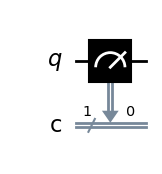

In [7]:
qc = QuantumCircuit(1, 1)
qc.measure(0, 0)
qc.draw('mpl')

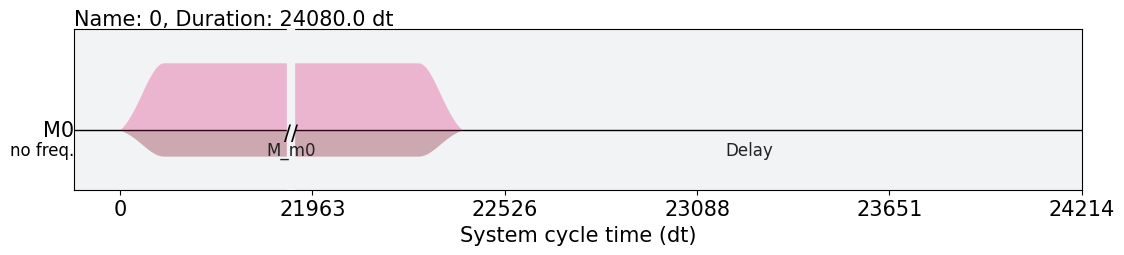

In [8]:
from qiskit import pulse

inst_sched_map = backend_defaults.instruction_schedule_map
measure = inst_sched_map.get('measure', qubits=[qubit])
x_pulse = inst_sched_map.get('x', qubits=[qubit])

### Collect the necessary channels
drive_chan = pulse.DriveChannel(qubit)
meas_chan = pulse.MeasureChannel(qubit)
acq_chan = pulse.AcquireChannel(qubit)

# Create the schedules for 0 and 1
schedule_0 = pulse.Schedule(name='0')
schedule_0 += measure
schedule_1 = pulse.Schedule(name='1')
schedule_1 += x_pulse
schedule_1 += measure << schedule_1.duration

schedule_0.draw()

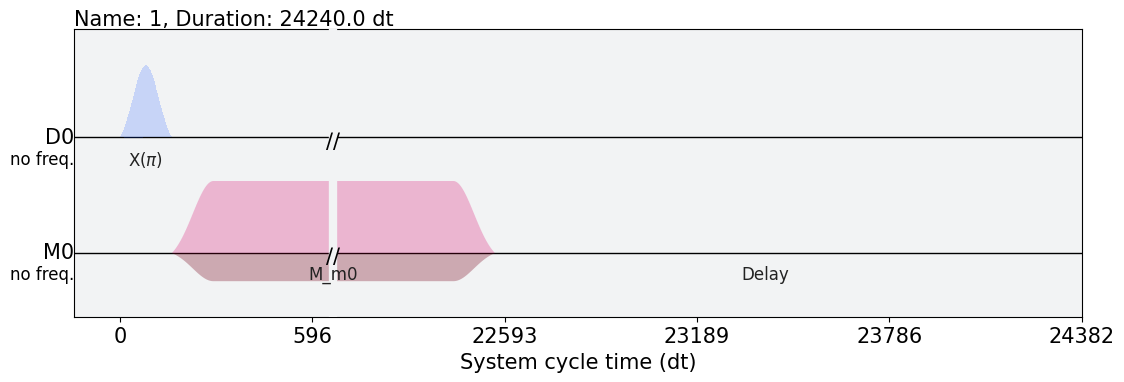

In [9]:
schedule_1.draw()

In [10]:
import numpy as np
# unit conversion factors -> all backend properties returned in SI 
# (Hz, sec, etc)
GHz = 1.0e9 # Gigahertz
MHz = 1.0e6 # Megahertz
kHz = 1.0e3
us = 1.0e-6 # Microseconds
ns = 1.0e-9 # Nanoseconds

frequency_span_Hz = 320 * kHz
frequency_step_Hz = 8 * kHz
center_frequency_Hz = backend_defaults.meas_freq_est[qubit]
print(f"Qubit {qubit} has an estimated readout frequency of {center_frequency_Hz / GHz} GHz.")
frequency_min = center_frequency_Hz - frequency_span_Hz / 2
frequency_max = center_frequency_Hz + frequency_span_Hz / 2
frequencies_GHz = np.arange(frequency_min / GHz, 
                            frequency_max / GHz, 
                            frequency_step_Hz / GHz)
print(f"The sweep will go from {frequency_min / GHz} GHz to {frequency_max / GHz} GHz\
      in steps of {frequency_step_Hz / MHz} MHz.")

Qubit 0 has an estimated readout frequency of 7.163170819 GHz.
The sweep will go from 7.163010819 GHz to 7.163330819 GHz      in steps of 0.008 MHz.


In [11]:
from qiskit import assemble
num_shots_per_frequency = 2048
frequencies_Hz = frequencies_GHz*GHz
schedule_los = [{meas_chan: freq} for freq in frequencies_Hz]

cavity_sweep_0 = assemble(schedule_0,
                               backend=backend, 
                               meas_level=1,
                               meas_return='avg',
                               shots=num_shots_per_frequency,
                               schedule_los=schedule_los)
cavity_sweep_1 = assemble(schedule_1,
                               backend=backend, 
                               meas_level=1,
                               meas_return='avg',
                               shots=num_shots_per_frequency,
                               schedule_los=schedule_los)

In [12]:
from qiskit.tools.monitor import job_monitor

# RUN the job on a real device
job_0 = backend.run(cavity_sweep_0)
job_monitor(job_0)
job_0.error_message()

job_1 = backend.run(cavity_sweep_1)
job_monitor(job_1)
job_1.error_message()

cavity_sweep_0_results = job_0.result()
cavity_sweep_1_results = job_1.result()

Job Status: job incurred error
Job Status: job incurred error    


IBMQJobFailureError: 'Unable to retrieve result for job 643181f014b1233a3890ff4e. Job has failed: The Qobj pulse type is not supported by the selected backend. Error code: 1108.'

In [ ]:
from qiskit_experiments.library import ResonatorSpectroscopy

exp = ResonatorSpectroscopy(physical_qubits=(0,), frequencies=frequencies_Hz)